In [1]:
from fastai.vision.all import *
import torchaudio
from sklearn.model_selection import StratifiedKFold
import librosa
from scipy import stats


In [2]:
df_train = pd.read_csv('/home/ubuntu/.kaggle/kaggle-pog-series-s01e02/train.csv')
df_test = pd.read_csv('/home/ubuntu/.kaggle/kaggle-pog-series-s01e02/test.csv')
submission = pd.read_csv('/home/ubuntu/.kaggle/kaggle-pog-series-s01e02/sample_submission.csv')
genre2id = pd.read_csv('/home/ubuntu/.kaggle/kaggle-pog-series-s01e02/genres.csv')


In [3]:
genre2id

,genre,genre_id
0,Electronic,0
1,Rock,1
2,Punk,2
3,Experimental,3
4,Hip-Hop,4
5,Folk,5
6,Chiptune / Glitch,6
7,Instrumental,7
8,Pop,8
9,International,9


In [4]:
train_path = Path('/home/ubuntu/.kaggle/resampled/resampled_train/')
test_path = Path('/home/ubuntu/.kaggle/resampled/resampled_test/')

In [5]:
train_files = get_files(train_path, extensions='.wav')


In [6]:
train_files

(#19909) [Path('/home/ubuntu/.kaggle/resampled/resampled_train/018663_16k.wav'),Path('/home/ubuntu/.kaggle/resampled/resampled_train/008647_16k.wav'),Path('/home/ubuntu/.kaggle/resampled/resampled_train/018904_16k.wav'),Path('/home/ubuntu/.kaggle/resampled/resampled_train/001706_16k.wav'),Path('/home/ubuntu/.kaggle/resampled/resampled_train/003820_16k.wav'),Path('/home/ubuntu/.kaggle/resampled/resampled_train/013023_16k.wav'),Path('/home/ubuntu/.kaggle/resampled/resampled_train/009569_16k.wav'),Path('/home/ubuntu/.kaggle/resampled/resampled_train/017429_16k.wav'),Path('/home/ubuntu/.kaggle/resampled/resampled_train/008264_16k.wav'),Path('/home/ubuntu/.kaggle/resampled/resampled_train/000141_16k.wav')...]

In [7]:
df_train

,song_id,filename,filepath,genre_id,genre
0,10150,010150.ogg,train/010150.ogg,7,Instrumental
1,7358,007358.ogg,train/007358.ogg,2,Punk
2,20573,020573.ogg,train/020573.ogg,5,Folk
3,11170,011170.ogg,train/011170.ogg,12,Old-Time / Historic
4,16662,016662.ogg,train/016662.ogg,1,Rock
...,...,...,...,...,...
19917,9337,009337.ogg,train/009337.ogg,0,Electronic
19918,8340,008340.ogg,train/008340.ogg,4,Hip-Hop
19919,16248,016248.ogg,train/016248.ogg,4,Hip-Hop
19920,11875,011875.ogg,train/011875.ogg,2,Punk


In [8]:
def get_y(filename):
    resample_name = filename.name.split('_')[0] + '.ogg'
    return df_train[df_train['filename']==resample_name]['genre_id'].values[0]

In [9]:
# /home/ubuntu/.kaggle/resampled/resampled_train/002093_16k.wav
# 3859
# /home/ubuntu/.kaggle/resampled/resampled_train/009074_16k.wav

In [10]:
get_y(train_files[0])

6

In [11]:
# Excluded unusual music thanks to this thread: https://www.kaggle.com/c/kaggle-pog-series-s01e02/discussion/312842
def get_items(path): 
    excluded_files = ["010449_16k.wav" , 
                      "005589_16k.wav" , 
                      "004921_16k.wav", 
                      "019511_16k.wav" , 
                      "013375_16k.wav" , 
                      "024247_16k.wav", 
                      "024156_16k.wav", 
                      "017400_16k.wav", 
                      "018390_16k.wav", 
                      "001975_16k.wav",
                      "008130_16k.wav",
                      "006054_16k.wav",
                      "002093_16k.wav",
                      "009074_16k.wav"
                     ]
    items = get_files(path, extensions='.wav')
    items = [item for item in items if item.name not in excluded_files]
    
    ## For fast iteration
#     items = [item for item in items if get_y(item) in ['Punk', 'Rock']]
#     items.shuffle()
    return L(items)

In [12]:
N_FFT = 2048
HOP_LEN = 512

In [13]:
items = get_items(train_path)

In [14]:
audio, sr = torchaudio.load(items[0])

In [15]:
signal_len = int(2048*63+1024)

In [16]:
start_idx = random.randint(0, audio.shape[1] - signal_len )
audio = audio[0,start_idx:start_idx+signal_len].unsqueeze(0)

In [17]:
audio_default = audio

In [18]:
class AudioTransform(Transform):
    def __init__(self, files, is_test=False):
        self.files = files
        self.is_test = is_test
        
    def encodes(self, i):
        filename = self.files[i]
        audio, sr = torchaudio.load(filename)
        audio = audio.squeeze()
        audio, index = librosa.effects.trim(audio, frame_length=1024, hop_length=256)  
        audio = audio.unsqueeze(0)
        signal_len = int(2048*63+1024)

        if audio.shape[1] < signal_len:
            pad_value = int((signal_len - audio.shape[1])/2) + 1
            if pad_value > audio.shape[1]:
                ## How to reflection instead of replicate ??
#                 print(i)
                audio = F.pad(audio, (pad_value,pad_value), mode='replicate')
            else:
                audio = F.pad(audio, (pad_value,pad_value), mode='reflect')
        else:
            start_idx = random.randint(0, audio.shape[1] - signal_len )
            audio = audio[0,start_idx:start_idx+signal_len].unsqueeze(0)
            
        audio = audio[:,:signal_len]
#         if (audio == 0).sum()/130048 > 0.8:
#             print((audio == 0).sum()/130048)
#             print(i)
#             print(self.files[i])
#         audio = audio.squeeze()
        if self.is_test:
            return audio, 0
        else: 
            y = get_y(filename)
            return audio, y
            
#         if self.is_valid:
#             print('is valid')


In [19]:
items = get_items(train_path)

In [20]:
items = items.shuffle()

In [21]:
len(items)

19895

In [22]:
train_items = items[:int(0.9*len(items))]
valid_items = items[int(0.9*len(items)):]

In [23]:
audio_tfm = AudioTransform(items, )

In [24]:
audio, y = audio_tfm(0, split_idx=0)

In [25]:
y

2

In [26]:
train_tl = TfmdLists(range(len(items)), AudioTransform(items))

In [27]:
test_items = get_items(test_path)

In [28]:
# pcts = []

# for audio, y in train_tl:
#     pcts.append((audio == 0).sum()/130048)

In [29]:
train_tl = TfmdLists(range(len(train_items)), AudioTransform(train_items))
valid_tl = TfmdLists(range(len(valid_items)), AudioTransform(valid_items))

In [30]:
test_tl = TfmdLists(range(len(test_items)), AudioTransform(test_items, is_test=True))

In [31]:
audio, genre = train_tl[0]

In [32]:
class AudioImage(fastuple):
    def show(self, ctx=None, **kwargs): 
        img, label = self
        return show_image(img, title=label, ctx=ctx, **kwargs)

In [33]:
class SpecTransform(Transform):
    def encodes(self, audio:torch.Tensor):  
        specgram = torchaudio.transforms.MelSpectrogram(sample_rate=16000, 
                                                    n_fft=N_FFT, 
                                                    win_length=N_FFT, 
                                                    hop_length=HOP_LEN*2,
                                                    center=True,
                                                    pad_mode="reflect",
                                                    power=2.0,
                                                    norm='slaney',
                                                    onesided=True,
                                                    n_mels=128,
                                                    mel_scale="htk"
                                                   )(audio)[0]
        specgram = torchaudio.transforms.AmplitudeToDB()(specgram)
        specgram = specgram - specgram.min()
        specgram = specgram/specgram.max()
        specgram = specgram.unsqueeze(0)
        return specgram

In [34]:
tfm = SpecTransform() 

In [35]:
a,b = tfm((audio, genre))

In [36]:
dls = DataLoaders.from_dsets(train_tl, 
                             valid_tl,     
                             test_tl,
                             after_item=[SpecTransform],
                             after_batch=[IntToFloatTensor])

In [37]:
dls = dls.cuda()

In [38]:
mixup = MixUp(0.2)

In [39]:
model = partial(xse_resnet50, pool=MaxPool)

In [40]:
learn = cnn_learner(dls, 
                    model, 
                    metrics=[accuracy, F1Score(average='micro')], 
                    pretrained=True, 
                    loss_func=LabelSmoothingCrossEntropy(), 
                    opt_func=ranger, 
                    n_out=19
                   )

In [41]:
learn.to_fp16()

In [42]:
## This is to make model works with 1-channel input
def alter_learner(learn, channels=1):
    learn.model[0][0][0].in_channels=channels
    learn.model[0][0][0].weight = torch.nn.parameter.Parameter(learn.model[0][0][0].weight[:,1,:,:].unsqueeze(1))

In [43]:
nchannels = 1
alter_learner(learn, nchannels)

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,2.615041,2.108344,0.409548,0.409548,02:01
1,2.279489,1.975330,0.443719,0.443719,01:59
2,2.169898,1.981212,0.419598,0.419598,01:57
3,2.138634,1.939248,0.458291,0.458291,01:58
4,2.104792,1.932798,0.456784,0.456784,01:57
5,2.080795,1.914901,0.452764,0.452764,01:58
6,2.062403,1.909672,0.452261,0.452261,01:58
7,2.043541,1.904243,0.463317,0.463317,01:58
8,2.032639,1.884561,0.477889,0.477889,01:57
9,2.022438,1.877398,0.466332,0.466332,01:58


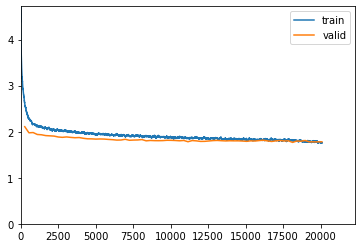

In [ ]:
learn.fit_flat_cos(80, 0.003, cbs=[CSVLogger(), mixup, ShowGraphCallback()])


In [ ]:
# test_items = get_items(test_path)

In [ ]:
preds_ls = []
for i in range(15):
    preds = learn.get_preds(ds_idx=2)
    preds_ls.append(np.array(preds[0]))

In [ ]:
preds_votes = [preds.argmax(axis=1) for preds in preds_ls]

In [ ]:
preds_votes = np.array(preds_votes)

In [ ]:
final_votes = stats.mode(preds_votes, axis=0)[0][0]

In [ ]:
final_votes.shape

In [ ]:
# preds_idx = final_preds.argmax(axis=1)
genre2id = pd.read_csv('/home/ubuntu/.kaggle/kaggle-pog-series-s01e02/genres.csv')
songid_preds = {int(file_path.name.split('_')[0]):_id for file_path, _id in zip(test_items,final_votes)}
submission['genre_id'] = submission['song_id'].map(songid_preds)
submission['genre_id'].fillna(0, inplace=True)
submission.loc[submission['song_id']==22612, 'genre_id'] = 1
submission.loc[submission['song_id']==24013, 'genre_id'] = 0

submission.genre_id = submission.genre_id.astype(int)
submission.to_csv(f"submission_final_{int(time.time())}.csv", index=False)

In [ ]:
submission

In [ ]:
# preds_kfold_learns = [get_preds(split_1fold) for split_1fold in splits_kfold]

In [ ]:
# preds_kfold = [pred_learn[0] for pred_learn in preds_kfold_learns]
# learns = [pred_learn[1] for pred_learn in preds_kfold_learns]

In [ ]:
# preds_kfold = [np.array(preds[0]) for preds in preds_kfold]

In [ ]:
# preds_list = [pred.argmax(axis=1) for pred in preds_kfold]

In [ ]:
# preds_array = np.array(preds_list)

In [ ]:
# values, counts = np.unique(preds_array,axis=0, return_counts=True)

In [ ]:
# Counter(preds_array[:,0]).most_common(1)[0][0]

In [ ]:
# final_votes = [Counter(preds_array[:,i]).most_common(1)[0][0] for i in range(preds_array.shape[1])]

In [ ]:
# final_preds = np.array(preds_kfold).mean(axis=0)

In [ ]:
# submission[submission['song_id']=="024013"]

In [ ]:
# def genreid_from_genre(genre):
#     return int(genre2id[genre2id['genre'] == genre]['genre_id'].values[0])